In [ ]:
import warnings
warnings.filterwarnings("ignore")

# 1 Dataset

In [ ]:
! pip install transformers datasets seqeval evaluate accelerate -U

In [ ]:
from datasets import load_dataset
dataset = load_dataset("AmazonScience/massive", "fa-IR")

/usr/local/lib/python3.10/dist-packages/huggingface_hub/utils/_token.py:88: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


Generating train split:   0%|          | 0/11514 [00:00<?, ? examples/s]

Generating validation split:   0%|          | 0/2033 [00:00<?, ? examples/s]

Generating test split:   0%|          | 0/2974 [00:00<?, ? examples/s]

# 2 Preprocessing

In [ ]:
import re

def extract_word_class_dict(annot_utt):
  word_class = {}
  pattern = r'\[([^[\]]+)\]'
  matches = re.findall(pattern, annot_utt)
  for m in matches:
    pair = m.split(':')
    for token in pair[1].strip().split():
      word_class[token] = pair[0].strip()

  return word_class

def build_tokens_and_labels(utt, annot_utt):
  tokens = utt.split()
  word_class_dict = extract_word_class_dict(annot_utt)
  labels = []
  for token in tokens:
    if token in word_class_dict:
      labels.append(word_class_dict[token])
    else:
      labels.append('none')

  return tokens, labels

In [ ]:
X_train = []
y_train = []
for datapoint in dataset['train']:
  utt, annot_utt = datapoint['utt'], datapoint['annot_utt']
  tokens, labels = build_tokens_and_labels(utt, annot_utt)
  X_train.append(tokens)
  y_train.append(labels)

In [ ]:
len(X_train),len(y_train)

(11514, 11514)

In [ ]:
X_valid = []
y_valid = []
for datapoint in dataset['validation']:
  utt, annot_utt = datapoint['utt'], datapoint['annot_utt']
  tokens, labels = build_tokens_and_labels(utt, annot_utt)
  X_valid.append(tokens)
  y_valid.append(labels)

In [ ]:
len(X_valid),len(y_valid)

(2033, 2033)

In [ ]:
X_test = []
y_test = []
for datapoint in dataset['test']:
  utt, annot_utt = datapoint['utt'], datapoint['annot_utt']
  tokens, labels = build_tokens_and_labels(utt, annot_utt)
  X_test.append(tokens)
  y_test.append(labels)

In [ ]:
len(X_test),len(y_test)

(2974, 2974)

In [ ]:
classes = []
for t in dataset['train']:
  for slot in t['slot_method']['slot']:
    classes.append(slot)
labels = sorted(list(set(classes)))
labels.insert(0,'none')

In [ ]:
id2label = dict(zip(range(len(labels)), labels))
label2id = dict(zip(labels, range(len(labels))))

# 3 LSTM-CRM

Using code from https://pytorch.org/tutorials/beginner/nlp/advanced_tutorial.html

In [ ]:
import torch
import torch.autograd as autograd
import torch.nn as nn
import torch.optim as optim

In [ ]:
def argmax(vec):
    # return the argmax as a python int
    _, idx = torch.max(vec, 1)
    return idx.item()

def prepare_sequence(seq, to_ix):
    idxs = [to_ix[w] for w in seq]
    return torch.tensor(idxs, dtype=torch.long)

# Compute log sum exp in a numerically stable way for the forward algorithm
def log_sum_exp(vec):
    max_score = vec[0, argmax(vec)]
    max_score_broadcast = max_score.view(1, -1).expand(1, vec.size()[1])
    return max_score + torch.log(torch.sum(torch.exp(vec - max_score_broadcast)))

In [ ]:
START_TAG = "<START>"
STOP_TAG = "<STOP>"

class BiLSTM_CRF(nn.Module):

    def __init__(self, vocab_size, tag_to_ix, embedding_dim, hidden_dim):
        super(BiLSTM_CRF, self).__init__()
        self.embedding_dim = embedding_dim
        self.hidden_dim = hidden_dim
        self.vocab_size = vocab_size
        self.tag_to_ix = tag_to_ix
        self.tagset_size = len(tag_to_ix)

        self.word_embeds = nn.Embedding(vocab_size, embedding_dim)
        self.lstm = nn.LSTM(embedding_dim, hidden_dim // 2,
                            num_layers=1, bidirectional=True)

        # Maps the output of the LSTM into tag space.
        self.hidden2tag = nn.Linear(hidden_dim, self.tagset_size)

        # Matrix of transition parameters.  Entry i,j is the score of
        # transitioning *to* i *from* j.
        self.transitions = nn.Parameter(torch.randn(self.tagset_size, self.tagset_size))

        # These two statements enforce the constraint that we never transfer
        # to the start tag and we never transfer from the stop tag
        self.transitions.data[tag_to_ix[START_TAG], :] = -10000
        self.transitions.data[:, tag_to_ix[STOP_TAG]] = -10000

        self.hidden = self.init_hidden()

    def init_hidden(self):
        return (torch.randn(2, 1, self.hidden_dim // 2),
                torch.randn(2, 1, self.hidden_dim // 2))

    def _forward_alg(self, feats):
        # Do the forward algorithm to compute the partition function
        init_alphas = torch.full((1, self.tagset_size), -10000.)
        # START_TAG has all of the score.
        init_alphas[0][self.tag_to_ix[START_TAG]] = 0.

        # Wrap in a variable so that we will get automatic backprop
        forward_var = init_alphas

        # Iterate through the sentence
        for feat in feats:
            alphas_t = []  # The forward tensors at this timestep
            for next_tag in range(self.tagset_size):
                # broadcast the emission score: it is the same regardless of
                # the previous tag
                emit_score = feat[next_tag].view(1, -1).expand(1, self.tagset_size)
                # the ith entry of trans_score is the score of transitioning to
                # next_tag from i
                trans_score = self.transitions[next_tag].view(1, -1)
                # The ith entry of next_tag_var is the value for the
                # edge (i -> next_tag) before we do log-sum-exp
                next_tag_var = forward_var + trans_score + emit_score
                # The forward variable for this tag is log-sum-exp of all the
                # scores.
                alphas_t.append(log_sum_exp(next_tag_var).view(1))
            forward_var = torch.cat(alphas_t).view(1, -1)
        terminal_var = forward_var + self.transitions[self.tag_to_ix[STOP_TAG]]
        alpha = log_sum_exp(terminal_var)
        return alpha

    def _get_lstm_features(self, sentence):
        self.hidden = self.init_hidden()
        embeds = self.word_embeds(sentence).view(len(sentence), 1, -1)
        lstm_out, self.hidden = self.lstm(embeds, self.hidden)
        lstm_out = lstm_out.view(len(sentence), self.hidden_dim)
        lstm_feats = self.hidden2tag(lstm_out)
        return lstm_feats

    def _score_sentence(self, feats, tags):
        # Gives the score of a provided tag sequence
        score = torch.zeros(1)
        tags = torch.cat([torch.tensor([self.tag_to_ix[START_TAG]], dtype=torch.long), tags])
        for i, feat in enumerate(feats):
            score = score + self.transitions[tags[i + 1], tags[i]] + feat[tags[i + 1]]
        score = score + self.transitions[self.tag_to_ix[STOP_TAG], tags[-1]]
        return score

    def _viterbi_decode(self, feats):
        backpointers = []

        # Initialize the viterbi variables in log space
        init_vvars = torch.full((1, self.tagset_size), -10000.)
        init_vvars[0][self.tag_to_ix[START_TAG]] = 0

        # forward_var at step i holds the viterbi variables for step i-1
        forward_var = init_vvars
        for feat in feats:
            bptrs_t = []  # holds the backpointers for this step
            viterbivars_t = []  # holds the viterbi variables for this step

            for next_tag in range(self.tagset_size):
                # next_tag_var[i] holds the viterbi variable for tag i at the
                # previous step, plus the score of transitioning
                # from tag i to next_tag.
                # We don't include the emission scores here because the max
                # does not depend on them (we add them in below)
                next_tag_var = forward_var + self.transitions[next_tag]
                best_tag_id = argmax(next_tag_var)
                bptrs_t.append(best_tag_id)
                viterbivars_t.append(next_tag_var[0][best_tag_id].view(1))
            # Now add in the emission scores, and assign forward_var to the set
            # of viterbi variables we just computed
            forward_var = (torch.cat(viterbivars_t) + feat).view(1, -1)
            backpointers.append(bptrs_t)

        # Transition to STOP_TAG
        terminal_var = forward_var + self.transitions[self.tag_to_ix[STOP_TAG]]
        best_tag_id = argmax(terminal_var)
        path_score = terminal_var[0][best_tag_id]

        # Follow the back pointers to decode the best path.
        best_path = [best_tag_id]
        for bptrs_t in reversed(backpointers):
            best_tag_id = bptrs_t[best_tag_id]
            best_path.append(best_tag_id)
        # Pop off the start tag (we dont want to return that to the caller)
        start = best_path.pop()
        assert start == self.tag_to_ix[START_TAG]  # Sanity check
        best_path.reverse()
        return path_score, best_path

    def neg_log_likelihood(self, sentence, tags):
        feats = self._get_lstm_features(sentence)
        forward_score = self._forward_alg(feats)
        gold_score = self._score_sentence(feats, tags)
        return forward_score - gold_score

    def forward(self, sentence):  # dont confuse this with _forward_alg above.
        # Get the emission scores from the BiLSTM
        lstm_feats = self._get_lstm_features(sentence)

        # Find the best path, given the features.
        score, tag_seq = self._viterbi_decode(lstm_feats)
        return score, tag_seq

In [ ]:
word_to_ix = {}
for sentence in X_train:
    for word in sentence:
        if word not in word_to_ix:
            word_to_ix[word] = len(word_to_ix)

In [ ]:
new_labels = labels.copy()
new_labels.append(START_TAG)
new_labels.append(STOP_TAG)
tag_to_ix = dict(zip(new_labels, range(len(new_labels))))
ix_to_tag = dict(zip(range(len(new_labels)), new_labels))

In [ ]:
EMBEDDING_DIM = 60
HIDDEN_DIM = 60

model = BiLSTM_CRF(len(word_to_ix), tag_to_ix, EMBEDDING_DIM, HIDDEN_DIM)
optimizer = optim.SGD(model.parameters(), lr=0.01, weight_decay=1e-4)

In [ ]:
# Check predictions before training
with torch.no_grad():
    print(X_train[0])
    precheck_sent = prepare_sequence(X_train[0], word_to_ix)
    score, tag_seq = model(precheck_sent)
    print([ix_to_tag[tag] for tag in tag_seq])
    print(f'Score: {score}')

['مرا', 'جمعه', 'ساعت', 'نه', 'صبح', 'بیدار', 'کن']
['date', 'coffee_type', 'cooking_type', 'time_zone', 'coffee_type', 'cooking_type', 'time_zone']
Score: 18.46399688720703


In [ ]:
from tqdm import tqdm

num_epochs = 10
num_examples = 100

# Make sure prepare_sequence from earlier in the LSTM section is loaded
for epoch in range(num_epochs):
    for sentence, tags in tqdm(zip(X_train[:num_examples], y_train[:num_examples]),desc=f'Epoch {epoch + 1}/{num_epochs}'):

        # Step 1. Remember that Pytorch accumulates gradients.
        # We need to clear them out before each instance
        model.zero_grad()

        # Step 2. Get our inputs ready for the network, that is,
        # turn them into Tensors of word indices.
        sentence_in = prepare_sequence(sentence, word_to_ix)
        targets = torch.tensor([tag_to_ix[t] for t in tags], dtype=torch.long)

        # Step 3. Run our forward pass.
        loss = model.neg_log_likelihood(sentence_in, targets)

        # Step 4. Compute the loss, gradients, and update the parameters by
        # calling optimizer.step()
        loss.backward()
        optimizer.step()

Epoch 1/10: 100it [00:14,  7.07it/s]
Epoch 2/10: 100it [00:11,  8.59it/s]
Epoch 3/10: 100it [00:11,  8.69it/s]
Epoch 4/10: 100it [00:11,  8.58it/s]
Epoch 5/10: 100it [00:11,  8.69it/s]
Epoch 6/10: 100it [00:11,  8.62it/s]
Epoch 7/10: 100it [00:11,  8.62it/s]
Epoch 8/10: 100it [00:11,  8.63it/s]
Epoch 9/10: 100it [00:11,  8.65it/s]
Epoch 10/10: 100it [00:11,  8.60it/s]


In [ ]:
# Check predictions after training
with torch.no_grad():
    print(X_train[0])
    precheck_sent = prepare_sequence(X_train[0], word_to_ix)
    score, tag_seq = model(precheck_sent)
    print([ix_to_tag[tag] for tag in tag_seq])
    print(f'Score: {score}')

['مرا', 'جمعه', 'ساعت', 'نه', 'صبح', 'بیدار', 'کن']
['none', 'none', 'none', 'time', 'time', 'none', 'none']
Score: 49.32266616821289


In [ ]:
model.eval()
all_predictions = []
all_labels = []

with torch.no_grad():
    for sentence, tags in tqdm(zip(X_train[:100], y_train[:100]), desc='Evaluation'):
        sentence_in = prepare_sequence(sentence, word_to_ix)
        targets = [tag_to_ix[t] for t in tags]
        score, predictions = model(sentence_in)
        all_predictions.extend(predictions)
        all_labels.extend(targets)

Evaluation: 100it [00:02, 48.81it/s]


In [ ]:
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, confusion_matrix

y_pred_flat = all_predictions.copy()
y_true_flat = all_labels.copy()

accuracy = accuracy_score(y_true_flat, y_pred_flat)
precision = precision_score(y_true_flat, y_pred_flat, average='micro')
recall = recall_score(y_true_flat, y_pred_flat, average='micro')
f1_micro = f1_score(y_true_flat, y_pred_flat, average='micro')
f1_macro = f1_score(y_true_flat, y_pred_flat, average='macro')

print("Accuracy:", accuracy)
print("Precision (Micro):", precision)
print("Recall (Micro):", recall)
print("F1 Score (Micro):", f1_micro)
print("F1 Score (Macro):", f1_macro)

Accuracy: 0.9282296650717703
Precision (Micro): 0.9282296650717703
Recall (Micro): 0.9282296650717703
F1 Score (Micro): 0.9282296650717703
F1 Score (Macro): 0.5157595528329908


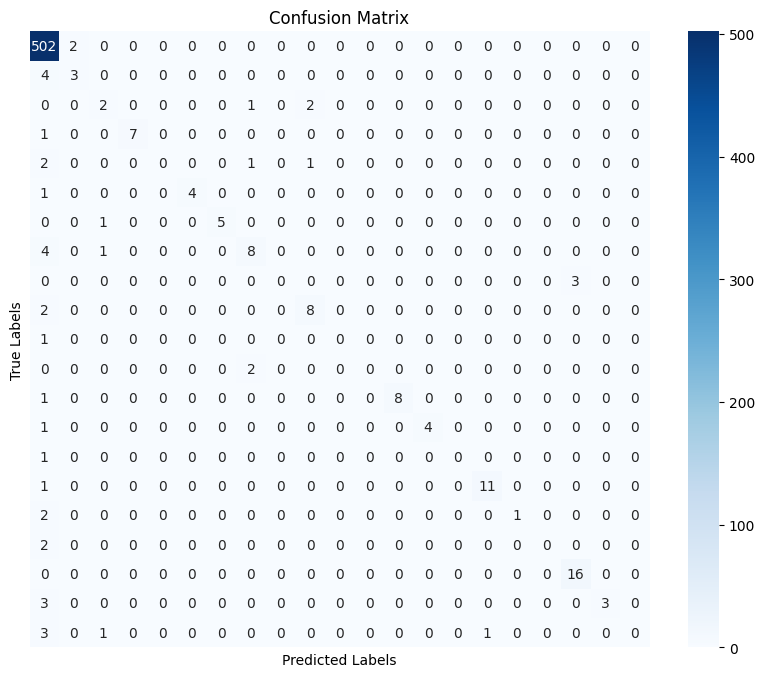

In [ ]:
import seaborn as sns
import matplotlib.pyplot as plt

conf_matrix = confusion_matrix(y_true_flat, y_pred_flat)

plt.figure(figsize=(10, 8))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', xticklabels=[], yticklabels=[])
plt.title('Confusion Matrix')
plt.xlabel('Predicted Labels')
plt.ylabel('True Labels')
plt.show()

# 4 Transformer

In [ ]:
from transformers import AutoTokenizer, AutoModel

In [ ]:
tokenizer = AutoTokenizer.from_pretrained("HooshvareLab/bert-fa-base-uncased")
model = AutoModel.from_pretrained("HooshvareLab/bert-fa-base-uncased")

config.json:   0%|          | 0.00/440 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/1.20M [00:00<?, ?B/s]

pytorch_model.bin:   0%|          | 0.00/654M [00:00<?, ?B/s]

/usr/local/lib/python3.10/dist-packages/torch/_utils.py:831: UserWarning: TypedStorage is deprecated. It will be removed in the future and UntypedStorage will be the only storage class. This should only matter to you if you are using storages directly.  To access UntypedStorage directly, use tensor.untyped_storage() instead of tensor.storage()
  return self.fget.__get__(instance, owner)()


In [ ]:
def get_label_encoding(labels):
  encoding = []
  for label in labels:
    encoding.append(label2id[label])
  return encoding

In [ ]:
X_train_encode = [tokenizer(sent, is_split_into_words=True, return_tensors='pt') for sent in X_train]
y_train_encode = [get_label_encoding(labels) for labels in y_train]
X_valid_encode = [tokenizer(sent, is_split_into_words=True, return_tensors='pt') for sent in X_valid]
y_valid_encode = [get_label_encoding(labels) for labels in y_valid]
X_test_encode = [tokenizer(sent, is_split_into_words=True, return_tensors='pt') for sent in X_test]
y_test_encode = [get_label_encoding(labels) for labels in y_test]

In [ ]:
def align_labels_with_tokens(labels, word_ids):
    new_labels = []
    current_word = None
    for word_id in word_ids:
        if word_id != current_word:
            current_word = word_id
            label = -100 if word_id is None else labels[word_id]
            new_labels.append(label)
        elif word_id is None:
            new_labels.append(-100)
        else:
            label = labels[word_id]
            if label % 2 == 1:
                label += 1
            new_labels.append(label)

    return new_labels

In [ ]:
word_lbls = y_train_encode[0]
word_ids = X_train_encode[0].word_ids()
print(word_lbls)
print(align_labels_with_tokens(word_lbls, word_ids))

[0, 13, 0, 48, 48, 0, 0]
[-100, 0, 13, 0, 48, 48, 0, 0, -100]


In [ ]:
from datasets import Dataset, DatasetDict

train_data = {"tokens": X_train, "labels": y_train_encode}
valid_data = {"tokens": X_valid, "labels": y_valid_encode}
test_data = {"tokens": X_test, "labels": y_test_encode}

train_dataset = Dataset.from_dict(train_data)
valid_dataset = Dataset.from_dict(valid_data)
test_dataset = Dataset.from_dict(test_data)

combined_dataset = DatasetDict({"train": train_dataset, "validation": valid_dataset, "test": test_dataset})

In [ ]:
def tokenize_and_align_labels(examples):
    tokenized_inputs = tokenizer(
        examples["tokens"], truncation=True, is_split_into_words=True
    )
    all_labels = examples["labels"]
    new_labels = []
    for i, labels in enumerate(all_labels):
        word_ids = tokenized_inputs.word_ids(i)
        new_labels.append(align_labels_with_tokens(labels, word_ids))

    tokenized_inputs["labels"] = new_labels
    return tokenized_inputs

In [ ]:
tokenized_datasets = combined_dataset.map(
    tokenize_and_align_labels,
    batched=True,
    remove_columns=combined_dataset["train"].column_names,
)

Map:   0%|          | 0/11514 [00:00<?, ? examples/s]

Map:   0%|          | 0/2033 [00:00<?, ? examples/s]

Map:   0%|          | 0/2974 [00:00<?, ? examples/s]

In [ ]:
tokenized_datasets

DatasetDict({
    train: Dataset({
        features: ['labels', 'input_ids', 'token_type_ids', 'attention_mask'],
        num_rows: 11514
    })
    validation: Dataset({
        features: ['labels', 'input_ids', 'token_type_ids', 'attention_mask'],
        num_rows: 2033
    })
    test: Dataset({
        features: ['labels', 'input_ids', 'token_type_ids', 'attention_mask'],
        num_rows: 2974
    })
})

In [ ]:
from transformers import DataCollatorForTokenClassification

data_collator = DataCollatorForTokenClassification(tokenizer=tokenizer)

In [ ]:
batch = data_collator([tokenized_datasets["train"][i] for i in range(2)])
batch["labels"]

tensor([[-100,    0,   13,    0,   48,   48,    0,    0, -100, -100, -100, -100],
        [-100,    0,    0,    0,    0,    0,   48,   48,   48,    0,    0, -100]])

In [ ]:
import numpy as np
import evaluate

metric = evaluate.load("seqeval")

def compute_metrics(eval_preds):
    logits, labels = eval_preds
    predictions = np.argmax(logits, axis=-1)

    true_labels = [[id2label[l] for l in label if l != -100] for label in labels]
    true_predictions = [
        [id2label[p] for (p, l) in zip(prediction, label) if l != -100]
        for prediction, label in zip(predictions, labels)
    ]
    all_metrics = metric.compute(predictions=true_predictions, references=true_labels)
    return {
        "precision": all_metrics["overall_precision"],
        "recall": all_metrics["overall_recall"],
        "f1": all_metrics["overall_f1"],
        "accuracy": all_metrics["overall_accuracy"],
    }

In [ ]:
from transformers import AutoModelForTokenClassification

model = AutoModelForTokenClassification.from_pretrained(
    "HooshvareLab/bert-fa-base-uncased",
    id2label=id2label,
    label2id=label2id,
)

Some weights of BertForTokenClassification were not initialized from the model checkpoint at HooshvareLab/bert-fa-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


In [ ]:
from transformers import TrainingArguments

args = TrainingArguments(
    "bert-fa-finetuned-intent",
    evaluation_strategy="epoch",
    save_strategy="epoch",
    learning_rate=2e-5,
    num_train_epochs=3,
    weight_decay=0.01,
    per_device_train_batch_size=64,
    per_device_eval_batch_size=64
    # push_to_hub=True,
)

In [ ]:
num_train_samples = 1000
num_val_samples = 250

train_subset = tokenized_datasets["train"].select(range(num_train_samples))
val_subset = tokenized_datasets["validation"].select(range(num_val_samples))

In [ ]:
from transformers import Trainer

trainer = Trainer(
    model=model,
    args=args,
    train_dataset=train_subset,
    eval_dataset=val_subset,
    data_collator=data_collator,
    compute_metrics=compute_metrics,
    tokenizer=tokenizer,
)

In [ ]:
trainer.train()

Epoch,Training Loss,Validation Loss,Precision,Recall,F1,Accuracy
1,No log,1.077889,0.292000,0.110106,0.159912,0.790419
2,No log,0.836404,0.369281,0.170437,0.233230,0.811377
3,No log,0.754505,0.497207,0.268477,0.348678,0.834132


TrainOutput(global_step=48, training_loss=1.2550230820973713, metrics={'train_runtime': 699.9063, 'train_samples_per_second': 4.286, 'train_steps_per_second': 0.069, 'total_flos': 26996146270848.0, 'train_loss': 1.2550230820973713, 'epoch': 3.0})

In [ ]:
model.eval()

num_test_samples = 100

all_preds = []
all_labels = []
with torch.no_grad():
    for tokens, labels in zip(X_test_encode[:num_test_samples], tokenized_datasets['test']['labels'][:num_test_samples]):
        outputs = model(**tokens)
        logits = outputs.logits
        preds = torch.argmax(logits, dim=2)

        all_preds.extend(preds.cpu().numpy())
        all_labels.append([0 if x == -100 else x for x in labels])

In [ ]:
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score
from seqeval.metrics import f1_score

pred_labels = [[id2label[id] for id in pred] for pred in all_preds]
true_labels = [[id2label[id] for id in label] for label in all_labels]

flat_pred_labels = [token for sublist in pred_labels for token in sublist]
flat_true_labels = [token for sublist in true_labels for token in sublist]

f1_micro = f1_score([flat_true_labels], [flat_pred_labels], average='micro')
accuracy = accuracy_score(flat_true_labels, flat_pred_labels)
classification_rep = classification_report(flat_true_labels, flat_pred_labels)
conf_matrix = confusion_matrix(flat_true_labels, flat_pred_labels)

print(f"F1 Micro: {f1_micro}")
print(f"Accuracy: {accuracy}")
print("Classification Report:\n", classification_rep)

F1 Micro: 0.13636363636363635
Accuracy: 0.8695652173913043
Classification Report:
                     precision    recall  f1-score   support

       artist_name       1.00      0.29      0.44         7
        color_type       0.00      0.00      0.00         3
              date       0.80      0.44      0.57        18
       device_type       1.00      0.08      0.14        13
         food_type       0.00      0.00      0.00         1
       house_place       0.00      0.00      0.00         7
         joke_type       0.00      0.00      0.00         1
         meal_type       0.00      0.00      0.00         1
        media_type       0.00      0.00      0.00         2
       music_genre       0.00      0.00      0.00         5
        news_topic       0.00      0.00      0.00        11
              none       0.87      1.00      0.93       705
        order_type       0.00      0.00      0.00         9
        place_name       0.00      0.00      0.00         6
    player_setti

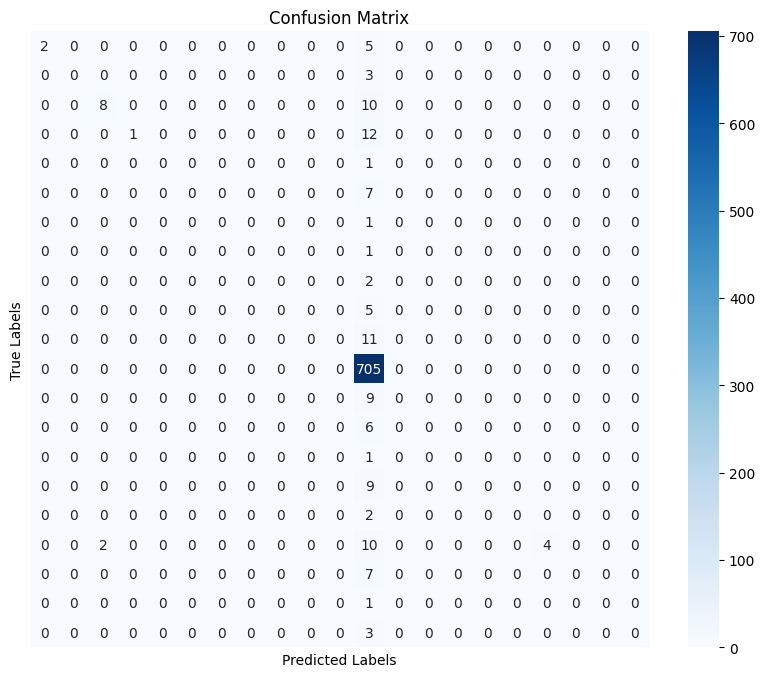

In [ ]:
import seaborn as sns
import matplotlib.pyplot as plt

plt.figure(figsize=(10, 8))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', xticklabels=[], yticklabels=[])
plt.title('Confusion Matrix')
plt.xlabel('Predicted Labels')
plt.ylabel('True Labels')
plt.show()